# **Lab 9.1 Generative Adversarial Network**
**NOTE :** Use the dataset from lab5.

In [31]:
import torch
from torch import nn
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os

## Architecture
Complete the GAN architecture that generates RGB images of size 128x128.

In [40]:
### START CODE HERE ###
class Generator(nn.Module):
    def __init__(self, z_dim=256,im_ch=1,hidden_dim=1024):
        super(Generator,self).__init__()
        
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, hidden_dim, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(hidden_dim // 2, hidden_dim // 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(hidden_dim // 4, hidden_dim // 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(hidden_dim // 8, hidden_dim // 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim // 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(hidden_dim // 16, im_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )


    def forward(self, noise):
        noise = noise.view(noise.size(0), noise.size(1), 1, 1)
        return self.gen(noise)
### END CODE HERE ###

In [41]:
### START CODE HERE ###
class Discriminator(nn.Module):
    def __init__(self,im_ch=1,hidden_dim=32):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(im_ch, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(hidden_dim * 8, hidden_dim * 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dim * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(hidden_dim * 16, 1, kernel_size=4),
            nn.Sigmoid()
        )



    def forward(self,image):
        return self.disc(image)

### END CODE HERE ###

Complete the function below. The `get_noise` function generates a random noise tensor that is typically used as input to a Generator
- `n_sample`: The number of noise samples to generate.

- `z_dim`: The dimensionality of each noise vector.

- `device`: The device on which the tensor will be allocated. By default, it is set to 'cuda'

In [42]:
### START CODE HERE ###

def get_noise(n_sample, z_dim, device='cuda'):
    return torch.randn(n_sample, z_dim, device=device)

### END CODE HERE ###

In [43]:
n_sample = 25
z_dim = 100
noise = get_noise(n_sample, z_dim, device='cpu')
assert noise.shape == (n_sample, z_dim), f"Expected shape {(n_sample, z_dim)}, but got {noise.shape}"

noise_cpu = get_noise(n_sample, z_dim, device='cpu')
assert noise_cpu.device.type == 'cpu', f"Expected tensor to be on 'cpu', but got {noise_cpu.device.type}"
assert noise.dtype == torch.float32, f"Expected dtype to be torch.float32, but got {noise.dtype}"

## Preparation
Prepare all training components such as the dataset, batch size, optimizer, and model, etc. No need to perform a train-test split.

In [46]:
### START CODE HERE ###

from torchvision.datasets import ImageFolder

data_dir = r'/Users/maikittitee/Documents/KMITL/1-2024/ImageProcess/repo/Lab9_GAN/data/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

### END CODE HERE ###

Display first batch of dataset.

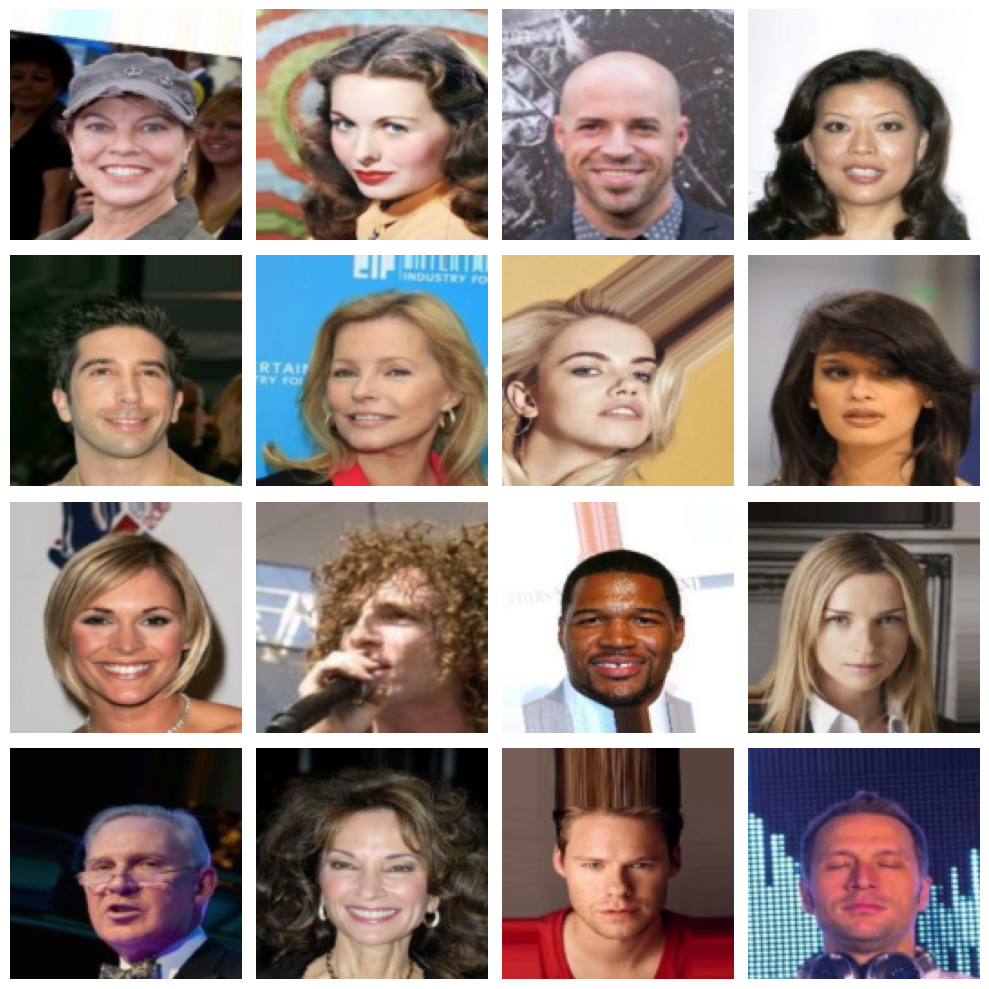

In [47]:
### START CODE HERE ###
import math
batch = next(iter(dataloader))

def imshow_grid(images):
    # print(images)
    n_images = len(images)
    grid_size = math.ceil(math.sqrt(n_images))  
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.ravel()  

    for i in range(len(axes)):
        if i < n_images:  # plot เฉพาะรูปที่มี
            image = images[i].permute(1, 2, 0).detach().cpu().numpy()
            image = (image + 1) / 2
            axes[i].imshow(image)
            axes[i].axis('off')  
        else:
            axes[i].axis('off')  # ซ่อน subplot ที่เกินออก

    plt.tight_layout()
    plt.show()

imshow_grid(batch[0])


### END CODE HERE ###

Use `get_noise` to generate noise with 25 samples, and then use the generator to generate images with that noise.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/1.png?raw=true)


</details>

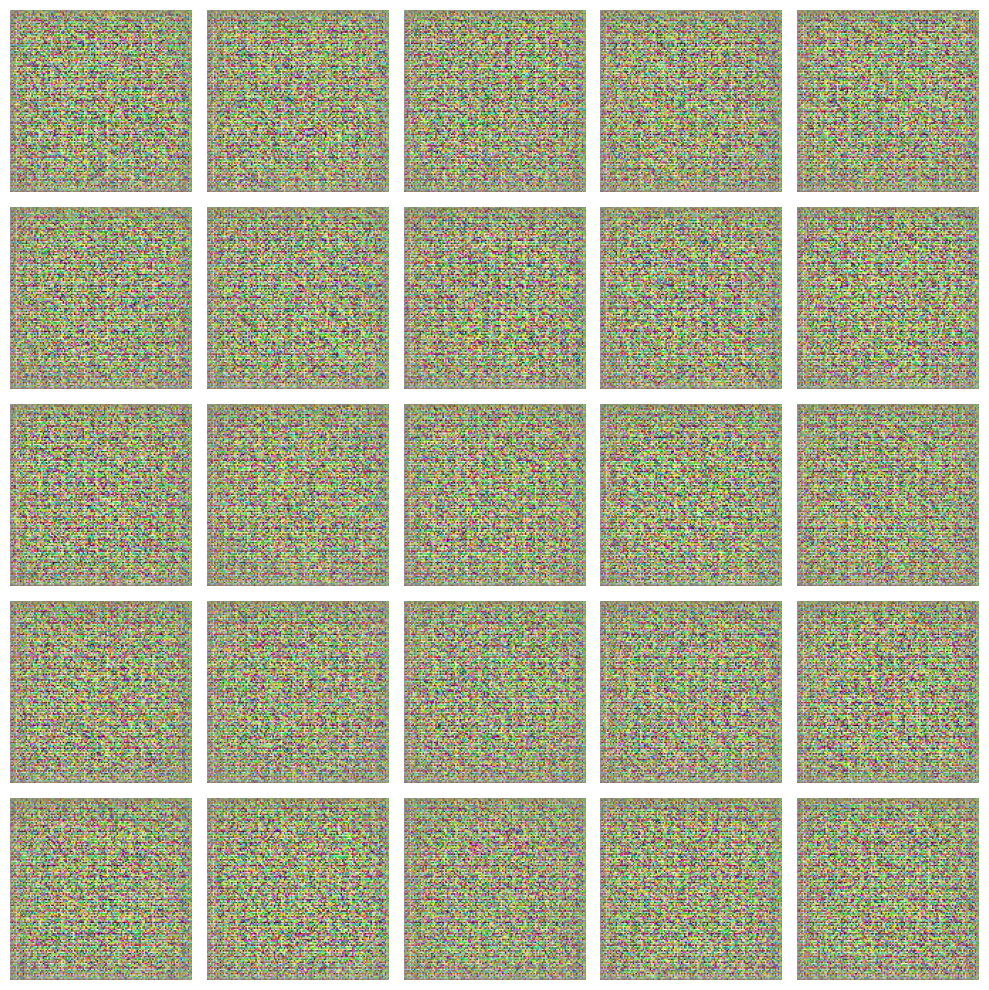

In [48]:
### START CODE HERE ###

generator = Generator(z_dim=256, im_ch=3, hidden_dim=1024)
noise = get_noise(25, 256, device='cpu')

fake_image = generator(noise)

imshow_grid(fake_image)

### END CODE HERE ###

Complete the training function that trains and logs the average loss for both the generator and discriminator, and generates sample images at each epoch (using the same input vector as the previous part) to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).
<details>
<summary>
<font size="3" color="orange">
<b>Expected output in tensorboard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/2.png?raw=true)


</details>


In [49]:
### START CODE HERE ###
import torchvision.utils as vutils
def train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    generator.to(device)
    discriminator.to(device)
    
    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for i, (gt, _) in progress_bar:
            gt = gt.to(device)
            batch_size = len(gt)
            # print(batch_size)
            disc_opt.zero_grad()
            
            noise = get_noise(batch_size, z_dim, device=device)
            fake = generator(noise)
            
            real_preds = discriminator(gt).view(-1)
            disc_loss_real = criterion(real_preds, torch.ones_like(real_preds))
            
            fake_preds = discriminator(fake.detach()).view(-1)
            disc_loss_fake = criterion(fake_preds, torch.zeros_like(fake_preds))
            
            disc_loss = (disc_loss_real + disc_loss_fake) / 2
            disc_loss.backward()
            disc_opt.step()
            
            avg_disc_loss += disc_loss.item()/ len(dataloader)
            
            gen_opt.zero_grad()
            
            fake_preds = discriminator(fake).view(-1)
            gen_loss = criterion(fake_preds, torch.ones_like(fake_preds))
            gen_loss.backward()
            gen_opt.step()
            
            avg_gen_loss += gen_loss.item()  / len(dataloader)
            
            progress_bar.set_postfix(gen_loss=avg_gen_loss, disc_loss=avg_disc_loss)
            
        
        
        if writer:
            writer.add_scalar('Loss/Generator', avg_gen_loss, epoch+1)
            writer.add_scalar('Loss/Discriminator', avg_disc_loss, epoch+1)
            
        with torch.no_grad():
            sample_images = generator(test_noise).cpu()
        grid = vutils.make_grid(sample_images, normalize=True)
        if writer:
            writer.add_image('Generated Images', grid, epoch+1)
            
        if checkpoint_path:
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_opt_state_dict': gen_opt.state_dict(),
                'disc_opt_state_dict': disc_opt.state_dict(),
                'epoch': epoch+1,
            }, f'{checkpoint_path}/checkpoint_epoch_{epoch+1}.pth')

        print(f'Epoch [{epoch+1}/{epochs}] | Gen Loss: {avg_gen_loss:.4f} | Disc Loss: {avg_disc_loss:.4f}')


### END CODE HERE ###

In [52]:
### START CODE HERE ###
import torch.optim as optim
# assert False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_dim = 256

generator = Generator(z_dim=256, im_ch=3)
discriminator = Discriminator(im_ch=3)

gen_opt = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

test_noise = get_noise(64, z_dim, device=device)

writer = SummaryWriter()

# checkpoint_path = r'/home/tdeephu/takdanai/Lab9_GAN/checkpoint'
checkpoint_path = r'/Users/maikittitee/Documents/KMITL/1-2024/ImageProcess/repo/Lab9_GAN/checkpoint'
train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim, 1, writer, checkpoint_path, device)

writer.close()

### END CODE HERE ###

Epoch [1/1] | Gen Loss: 3.9529 | Disc Loss: 0.4159


Test Genereate the image.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/3.png?raw=true)


</details>

/var/folders/18/68128y7572q_vzm7cwyy7hjw0000gn/T/ipykernel_67435/3774813005.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dicts = torch.load(r'/Users/maikittitee

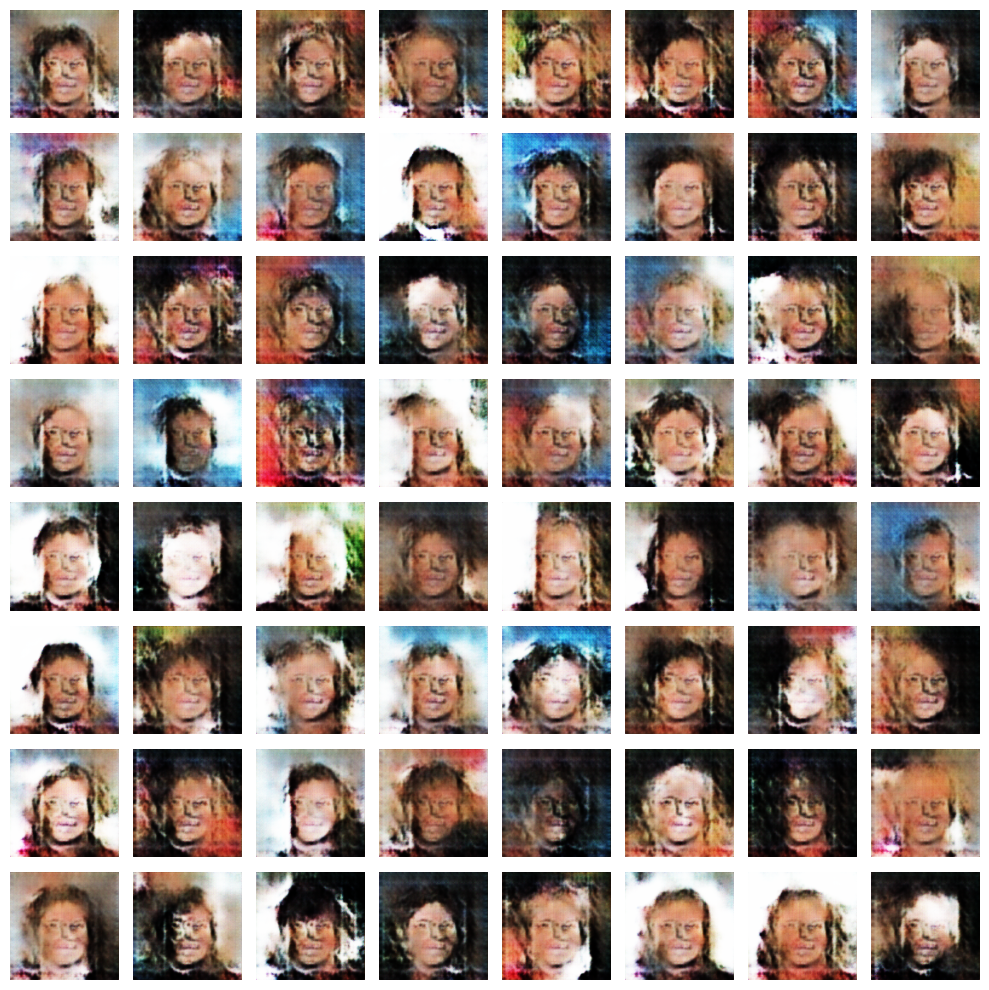

In [53]:
### START CODE HERE ###

device = 'cpu'

generator = Generator(z_dim=256, im_ch=3).to(device)
state_dicts = torch.load(r'/Users/maikittitee/Documents/KMITL/1-2024/ImageProcess/repo/Lab9_GAN/checkpoint/checkpoint_epoch_1.pth', map_location=device)
generator.load_state_dict(state_dicts['generator_state_dict'])

noise = get_noise(64, 256, device=device)

fake_image = generator(noise)

imshow_grid(fake_image)

### END CODE HERE ###

---

# Question
1. In the architecture of a discriminator, if the last layer is not a fully connected layer and the output is in a 3D tensor format rather than a 1D vector, how would you compute the Binary Cross-Entropy Loss (BCELoss) in this case?

2. If the architecture of the generator includes one or more hidden fully connected layers before the output layer, how would this affect the quality or characteristics of the generated output? 

3. When alternating between training the generator and the discriminator in a GAN, at which level should this switching occur to achieve optimal results—should it be done at the epoch level, the iteration level, or the batch level?